In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import copy
import time
import sys
import math
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize)
rng = np.random.default_rng()

# Maternal lineage

In [2]:
def trace_interesting_lines(p, N=1000, n=10000000, tracked_parental_lines=5, tracked_extreme_weights=10):
    """
    Traces weights of maternal, paternal and mixed lineages as well as maximal and minimal weights backwards in time.
    
            Parameters:
                    p (float in [0,1]): Portion of individuals weight that goes to mother
                    N (int): Population size
                    n (int): Number of generations to go in past
                    tracked_parental_lines (int): Number of the first maternal/paternal lines of which weights are tracked.
                    A low number should be enough since they coaless. Scales poorly in complexity and space
                    tracked_extreme_weights (int): Number of the biggest and smallest weightsthat are tracked
                    
            Returns:
                    List of:
                            Weights (list of floats, shape=(,N)): Weights of population n generations in the past
                            max_weights (list of lists, shape=(tracked_extreme_weights,n/100)): Biggest weights over all n 
                            generations in steps of 100 generations
                            min_weights (list of lists, shape=(tracked_extreme_weights,n/100)): Smallest weights over all n 
                            generations in steps of 100 generations
                            motherlines_weights (list of lists, shape=(tracked_parental_lines,n/100)): Weights of the tracked
                            maternal lines over all n generations in steps of 100 generations
                            fatherlines_weights (list of lists, shape=(tracked_parental_lines,n/100)): Weights of the tracked
                            paternal lines over all n generations in steps of 100 generations
                            coalece_mother (int): Coalescence time of all N maternal lines (up to 99 larger than in actuality)
                            coalece_father (int): Coalescence time of all N paternal lines (up to 99 larger than in actuality)
                            father_mother_weight (list of floats, shape=(,n/100)): Weight of a mixed maternal and paternal line 
                            starting from Individual 0 over all n generations
    """
    # The following are the initialisations of the tracked objects
    Weights = np.ones(N)
    indices = np.arange(0, N, 1, dtype=int)
    max_weights = [[] for i in range(tracked_extreme_weights)] # Only the values, not the positions of max lines is tracked
    min_weights = [[] for i in range(tracked_extreme_weights)] # Only the values, not the positions of min lines is tracked
    motherlines_weights = [[1.0] for i in range(tracked_parental_lines)] # Current weights of the tracked paternal lines
    indi_motherlines = list(np.arange(0, N, 1, dtype=int)) # Current position of the tracked paternal lines
    fatherlines_weights = [[1.0] for i in range(tracked_parental_lines)] # Current weights of the tracked paternal lines
    indi_fatherlines = list(np.arange(0, N, 1, dtype=int)) # Current position of the tracked paternal lines
    father_mother_weight = [1.0] # Current weight of the mixed maternal and paternal line
    indi_father_mother = 0 # Position of the mixed maternal and paternal line (at time 0)
    coalece_mother = 0 # Will be the time of coalescence of all maternal lines +-100 
    coalece_father = 0 # Will be the time of coalescence of all paternal lines +-100 
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa] = 0
        indi_motherlines = [mu if x == kappa else x for x in indi_motherlines]
        "List of all N current positions of the maternal lineages from the start"
        indi_fatherlines = [pi if x == kappa else x for x in indi_fatherlines]
        "List of all N current positions of the paternal lineages from the start"
        if kappa == indi_father_mother: 
            "Update of the mixed maternal and paternal line. Iff the position changes on even time steps, it changes to mother."
            if (i % 2) == 0:
                indi_father_mother = mu
            else:
                indi_father_mother = pi
        if (i % 100) == 99: # Only update every 100 time steps. Otherwise too slow
            w = copy.deepcopy(Weights)
            w.sort()
            w_not_0 = np.where(w != 0)[0]
            for m in range(tracked_extreme_weights): # Update of minimal and maximal lines
                max_weights[m].append(w[-(m+1)])
                min_weights[m].append(w[w_not_0[m]]) 
            for l in range(tracked_parental_lines): # Update of maternal and paternal lines
                motherlines_weights[l].append(Weights[indi_motherlines[l]])
                fatherlines_weights[l].append(Weights[indi_fatherlines[l]])
            if coalece_mother == 0: # Check if all N maternal lines have coalesced in the last 100 time steps
                if min(indi_motherlines) == max(indi_motherlines):
                    coalece_mother = i
            if coalece_father == 0: # Check if all N paternal lines have coalesced in the last 100 time steps
                if min(indi_fatherlines) == max(indi_fatherlines):
                    coalece_father = i
            father_mother_weight.append(Weights[indi_father_mother])
        if (i % 10000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    return [list(Weights), max_weights, min_weights,  motherlines_weights, fatherlines_weights,
            coalece_mother, coalece_father, father_mother_weight]

### Note that for all tracked objects, the position [1,...,N] changes over time

## p=1/2

In [40]:
start = time.time()

N = 1000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
interesting_lines_3 = trace_interesting_lines(p=1/2, N=N, n=n, tracked_parental_lines=5, tracked_extreme_weights=5)

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")

20.1 minutes


#### Maternal vs. Max

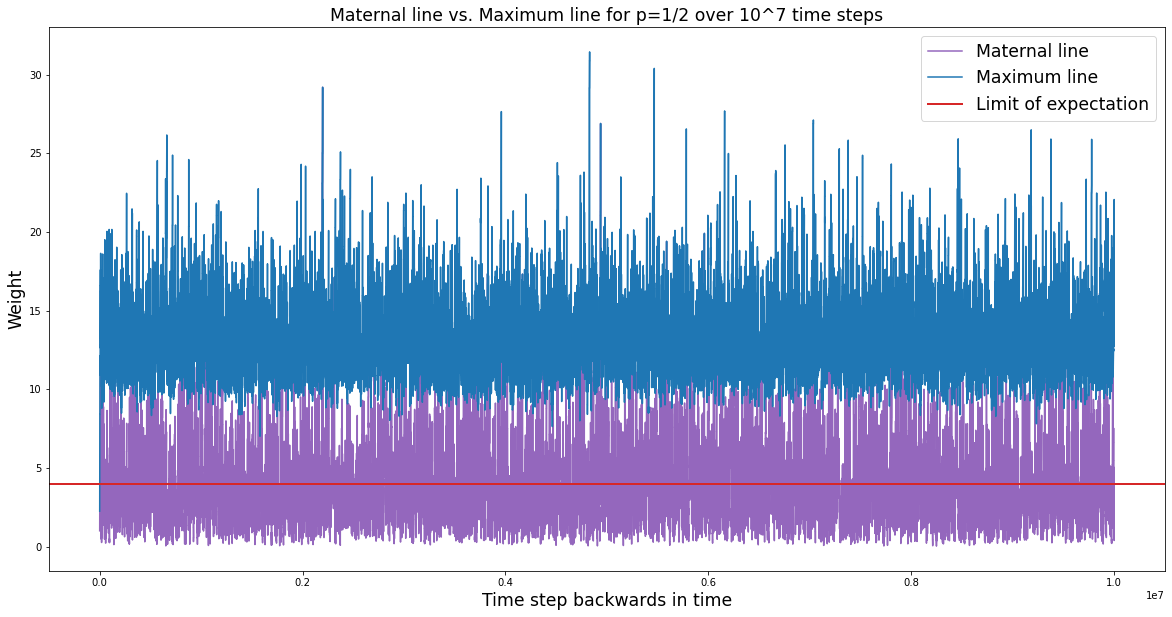

In [51]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

 
plt.plot(times, np.array(interesting_lines_3[3][i]), label="Maternal line", 
         color="tab:purple") # Plots one maternal lineage's weights over time

plt.plot(times[1:], interesting_lines_3[1][0], label="Maximum line", 
         color="tab:blue") # Plots running maximum weight

plt.axhline(y = 3.99, label = 'Limit of expectation', ls="-", lw=2, color="tab:red")
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("Weight", fontsize="xx-large")
plt.title("Maternal line vs. Maximum line for p=1/2 over 10^7 time steps", fontsize="xx-large")
plt.legend(fontsize="xx-large")

## p=4/N

In [54]:
start = time.time()

N = 1000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
interesting_lines_5 = trace_interesting_lines(p=4/N, N=N, n=n, tracked_parental_lines=1, tracked_extreme_weights=1)

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")

20.1 minutes


#### Maternal vs. Max 

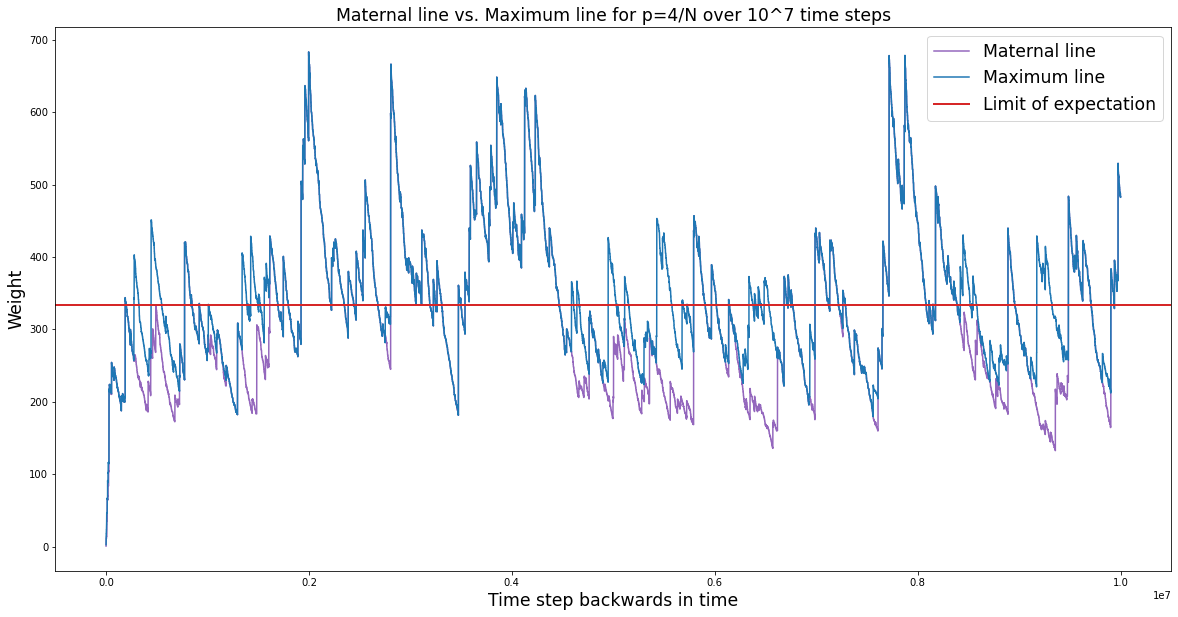

In [56]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

 
plt.plot(times, np.array(interesting_lines_5[3][0]), label="Maternal line", 
         color="tab:purple") # Plots one maternal lineage's weights over time

plt.plot(times[1:], interesting_lines_5[1][0], label="Maximum line", 
         color="tab:blue") # Plots running maximum weight

plt.axhline(y = 333.56, label = 'Limit of expectation', ls="-", lw=2, color="tab:red")
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("Weight", fontsize="xx-large")
plt.title("Maternal line vs. Maximum line for p=4/N over 10^7 time steps", fontsize="xx-large")
plt.legend(fontsize="xx-large")

## p=1/N

In [52]:
start = time.time()

N = 1000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
interesting_lines = trace_interesting_lines(p=1/N, N=N, n=n, tracked_parental_lines=5, tracked_extreme_weights=5)

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")

20.1 minutes


#### Coalescence of maternal lineages

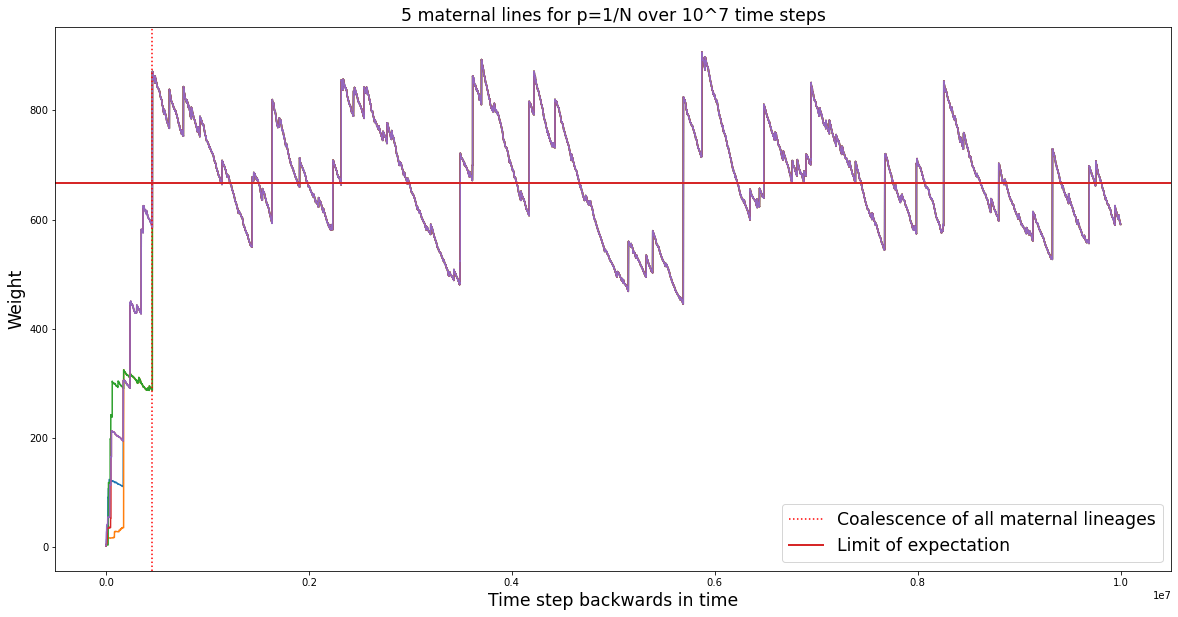

In [57]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

for i in range(5): # Plots the values of the 5 tracked maternal lineages weights over time
    plt.plot(times, np.array(interesting_lines[3][i]))

plt.axvline(x = interesting_lines[5], color = 'r', label = 'Coalescence of all maternal lineages', ls=":")
plt.axhline(y = 666.89, label = 'Limit of expectation', ls="-", lw=2, color="tab:red")
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("Weight", fontsize="xx-large")
plt.title("5 maternal lines for p=1/N over 10^7 time steps", fontsize="xx-large")
plt.legend(fontsize="xx-large")

#### Maternal vs. Max

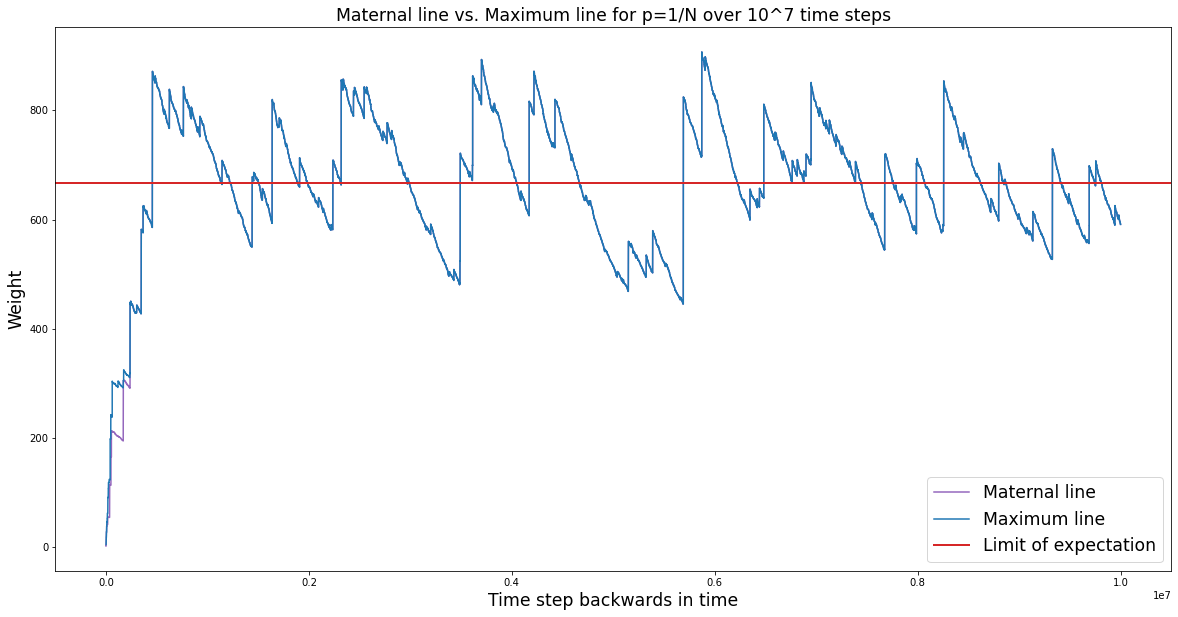

In [53]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

 
plt.plot(times, np.array(interesting_lines[3][i]), label="Maternal line", 
         color="tab:purple") # Plots one maternal lineage's weights over time

plt.plot(times[1:], interesting_lines[1][0], label="Maximum line", 
         color="tab:blue") # Plots running maximum weight

plt.axhline(y = 666.89, label = 'Limit of expectation', ls="-", lw=2, color="tab:red")
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("Weight", fontsize="xx-large")
plt.title("Maternal line vs. Maximum line for p=1/N over 10^7 time steps", fontsize="xx-large")
plt.legend(fontsize="xx-large")

## p=2/(9N)

In [58]:
start = time.time()

N = 1000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
interesting_lines_4 = trace_interesting_lines(p=2/(9*N), N=N, n=n, tracked_parental_lines=1, tracked_extreme_weights=1)

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")

20.1 minutes


#### Maternal vs. Max

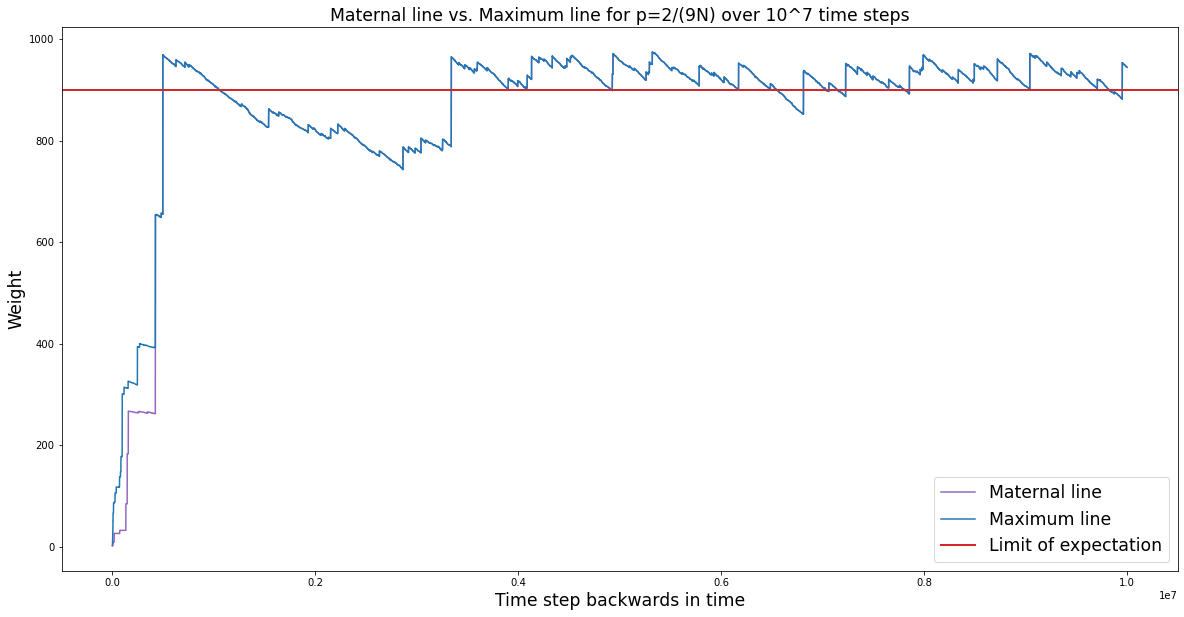

In [59]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

 
plt.plot(times, np.array(interesting_lines_4[3][0]), label="Maternal line", 
         color="tab:purple") # Plots one maternal lineage's weights over time

plt.plot(times[1:], interesting_lines_4[1][0], label="Maximum line", 
         color="tab:blue") # Plots running maximum weight

plt.axhline(y = 900.1, label = 'Limit of expectation', ls="-", lw=2, color="tab:red")
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("Weight", fontsize="xx-large")
plt.title("Maternal line vs. Maximum line for p=2/(9N) over 10^7 time steps", fontsize="xx-large")
plt.legend(fontsize="xx-large")

## p=1/N^2

In [37]:
start = time.time()

N = 1000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
interesting_lines_2 = trace_interesting_lines(p=1/(N*N), N=N, n=n, tracked_parental_lines=5, tracked_extreme_weights=5)

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")

19.9 minutes


#### Maternal vs. Max

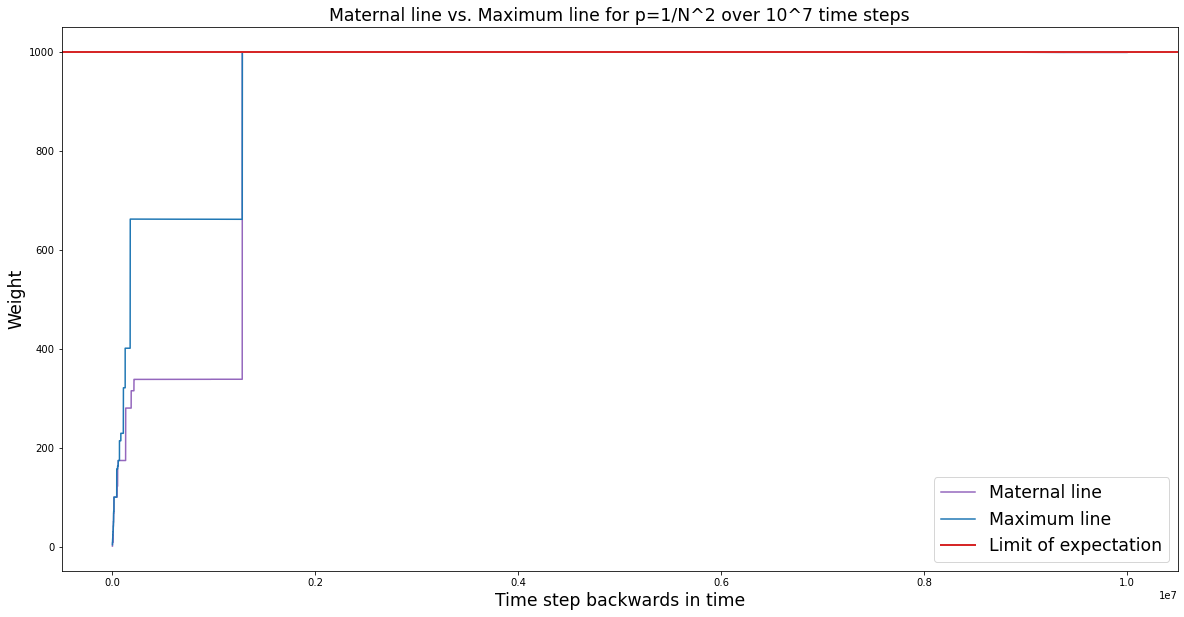

In [48]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

 
plt.plot(times, np.array(interesting_lines_2[3][i]), label="Maternal line", 
         color="tab:purple") # Plots one maternal lineage's weights over time

plt.plot(times[1:], interesting_lines_2[1][0], label="Maximum line", 
         color="tab:blue") # Plots running maximum weight

plt.axhline(y = 999.5, label = 'Limit of expectation', ls="-", lw=2, color="tab:red")
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("Weight", fontsize="xx-large")
plt.title("Maternal line vs. Maximum line for p=1/N^2 over 10^7 time steps", fontsize="xx-large")
plt.legend(fontsize="xx-large")

# Maximum lines in log plot

## p=1/N

Text(0.5, 1.0, '5 maximum weights for p=1/N over 10^7 time steps in log plot')

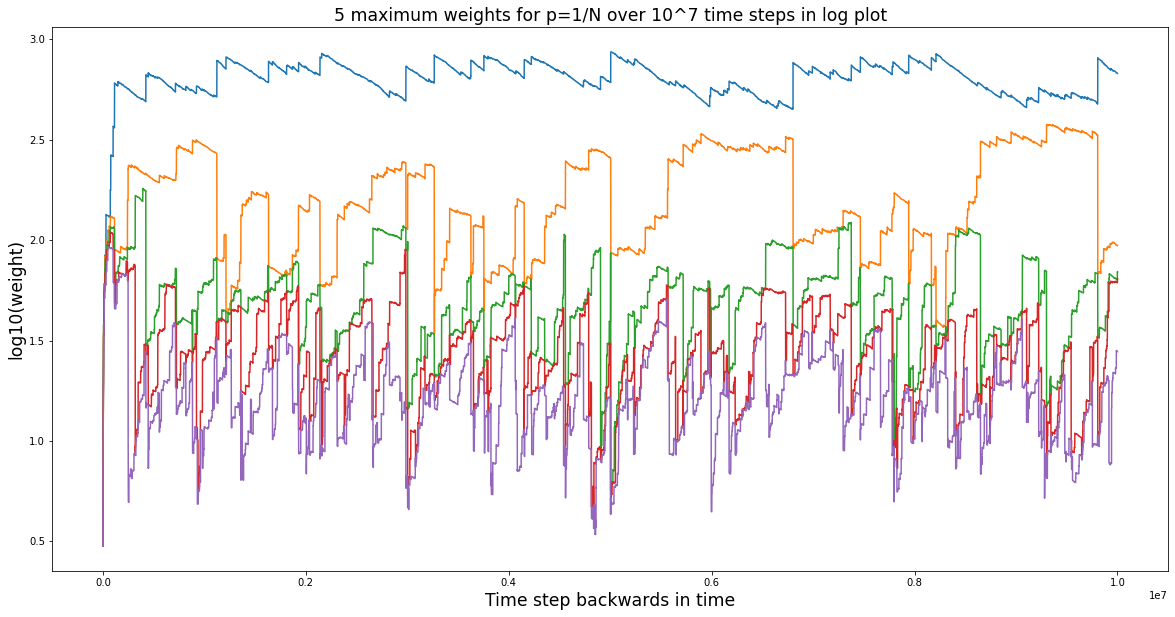

In [31]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

times = [100*(i) for i in range(100001)] #Plotted time steps backwards in time

for i in range(5): # Plots the values of the 5 maximal weights over time
    plt.plot(times[1:], np.log10(np.array(interesting_lines[1][i])))
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("log10(weight)", fontsize="xx-large")
plt.title("5 maximum weights for p=1/N over 10^7 time steps in log plot", fontsize="xx-large")

## p=1/N^2

Text(0.5, 1.0, '5 maximum weights for p=1/N^2 over 10^7 time steps in log plot')

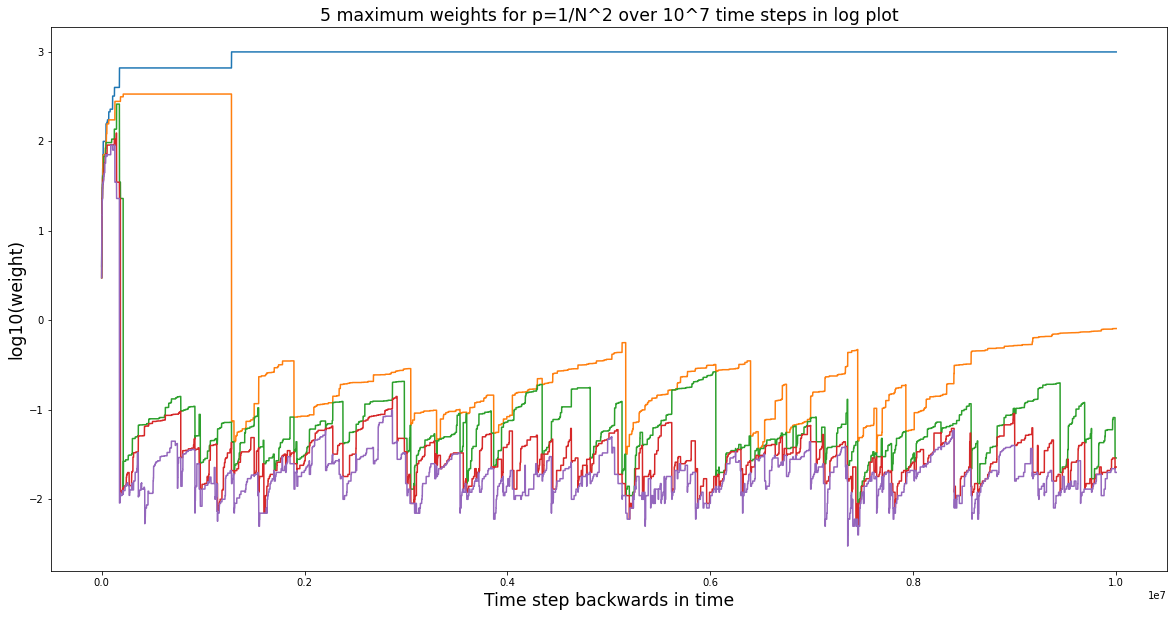

In [41]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

times = [100*(i) for i in range(100001)] #Plotted time steps backwards in time

for i in range(5): # Plots the values of the 5 maximal weights over time
    plt.plot(times[1:], np.log10(np.array(interesting_lines_2[1][i])))
    
plt.xlabel("Time step backwards in time", fontsize="xx-large")
plt.ylabel("log10(weight)", fontsize="xx-large")
plt.title("5 maximum weights for p=1/N^2 over 10^7 time steps in log plot", fontsize="xx-large")